## Input

In [408]:
filename_input = "AXM-0643-230420z-VVDN-R01-arinc633.xml"  # a320 , 
engine_efficiency_input = 0.4 
wingspan_input = 37.57
non_volatile_emissions_index_input = 1500000000000000 # 1.897462e15
n_engine_input = 2
thrust_setting_input = 0.22  # 
true_airspeed_input = 226.099920796651  # true airspeed, m/s
humidity_scaling_input= "ConstantHumidityScaling(rhi_adj=0.98)"


## Get Flight Data

In [411]:
import xml.etree.ElementTree as et 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pycontrails import Flight, Aircraft
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling

xtree = et.parse("./data/" + filename_input)
xroot = xtree.getroot()

#M633 Supplementary Header
header_s_633 = xroot[1]
flight_origin_date = header_s_633[0].get('flightOriginDate')
flight_number = header_s_633[0][0][1][0].text 
dep_airport_name = header_s_633[0][1].get('airportName')
arr_airport_name = header_s_633[0][2].get('airportName')

aircraft_reg = header_s_633[1].get('aircraftRegistration')
aircraft_subtype = header_s_633[1][0].get('airlineSpecificSubType')
aircraft_model = header_s_633[1][0][0].text 

print("Flight No: ", flight_number)
print("Flight Origin Date: " , flight_origin_date)
print("Departure:", dep_airport_name)
print("Arrival:", arr_airport_name)
print("Aircraft Reg: " , aircraft_reg) 
print("Aircraft SubType: " , aircraft_subtype) 
print("Aircraft Model: " , aircraft_model) 

#M633 FlightInfo
flight_info = xroot[2]
aircraft_reg = header_s_633[1].get('aircraftRegistration')
atc_callsign = flight_info.get('aTCCallsign')

print("Aircraft Reg: ", aircraft_reg) 
print("ATC Call Sign: ", atc_callsign) 

#M633 FlightPlan Header
flight_plan_header = xroot[4]

performance_factor = flight_plan_header[1].text # ('PerformanceFactor')
fuel_flow_avg = flight_plan_header[2][0][0].text
fuel_flow_holding = flight_plan_header[2][1][0].text
fms_route_name = flight_plan_header[3].get('fMSRouteName') #.text
route_name = flight_plan_header[3].get('routeName')
wind_direction_avg = flight_plan_header[3][0][0][0].text
wind_speed_avg = flight_plan_header[3][0][1][0].text
ground_distance = flight_plan_header[3][9][0].text
air_distance = flight_plan_header[3][10][0].text
greatcircle_distance = flight_plan_header[3][11][0].text

print("Performance Factor:" , performance_factor)
print("Fuel Flow Avg (Lb/h):" , fuel_flow_avg)
print("Fuel Flow Holding (Lb/h):" , fuel_flow_holding)
print("Route Name:" , fms_route_name, "(", route_name ,")" )
print("Wind Direction Avg (Deg):", wind_direction_avg)
print("Wind Direction Speed (Kt):", wind_speed_avg)
print("Distance - Ground (NM):", ground_distance) 
print("Distance - Air (NM):", air_distance) 
print("Distance - Great Circule (NM):", greatcircle_distance) 

#M633 Weight Header
weight_header = xroot[6]
takeoff_weight = int(weight_header[3][0][0].text)/2.205
landing_weight = int(weight_header[4][0][0].text)/2.205
burn = int(takeoff_weight) - int(landing_weight)

print("Weight - Take Off (Kgs):", int(takeoff_weight))
print("Weight - Landing (Kgs):", int(landing_weight))
print("Fuel Burn (Kgs)", burn)

import pandas as pd
from datetime import datetime, timedelta

# Waypoints
waypoints = xroot[7]
df_cols = ["sequence_no", "waypoint_name", 
           "latitude", "longitude", 
           "altitude", "elapsed_time", "mach_number", "true_airspeed", "indicated_airspeed", "engine_efficiency", "time", "burn_off", "c"]
rows = []

for wp in waypoints:
#for wp in xroot.iter('Waypoint'): 
    sequence_no = int(wp.get('sequenceId'))
    waypoint_name = wp.get('waypointName')
    lat = float(wp[0].get('latitude'))/3600
    long = float(wp[0].get('longitude'))/3600
    altitude, burn_off, fuel_flow = 0,0,0.0
    
    for child in wp:
        if child.tag == '{http://aeec.aviation-ia.net/633}Altitude':
            altitude = (float(child[0][0].text)*100)/3.218  if child[0][0] is not None else 0
        if child.tag == '{http://aeec.aviation-ia.net/633}BurnOff':
            burn_off = float(child[0][0].text)/2.205
        if child.tag == '{http://aeec.aviation-ia.net/633}TimeOverWaypoint':
            timestamp = child[0][0].text
            date_format = '%Y-%m-%dT%H:%M:%S'
            time = datetime.strptime(timestamp, date_format)
        if child.tag == '{http://aeec.aviation-ia.net/633}TimeFromPreviousWaypoint':
            split = child[0][0].text.split("H")
            minutes = split[1] 
            seconds = float(minutes.split("M")[0])*60
            #else:
            #    fuel_flow = 0
            #time = time - timedelta(days=13)
        if child.tag == '{http://aeec.aviation-ia.net/633}MachNumber':
            mach_number = float(child[0][0].text) # if mach_no_node is not None else 0
        if child.tag == '{http://aeec.aviation-ia.net/633}TrueAirSpeed':
            true_airspeed = float(child[0][0].text) # if mach_no_node is not None else 0
        if child.tag == '{http://aeec.aviation-ia.net/633}IndicatedAirSpeed':
            indicated_airspeed = float(child[0][0].text) # if mach_no_node is not None else 0
            
        rows.append({"sequence_no": sequence_no,
                 "waypoint_name": waypoint_name,
                 "latitude": lat,
                 "longitude": long, 
                 "altitude": altitude,
                 "elapsed_time": seconds, 
                 "time": time, 
                 "burn_off": burn_off,
                 "mach_number": mach_number,
                 "true_airspeed": true_airspeed, 
                 "indicated_airspeed": indicated_airspeed,
                 "engine_efficiency": 0.0
                })

# Set Takeoff Weight 
rows[0]['c'] = takeoff_weight

out_df = pd.DataFrame(rows, columns = df_cols)
new_col = 'c'

def apply_func_decorator(func):
    prev_row = {}
    def wrapper(curr_row, **kwargs):
        val = func(curr_row, prev_row)
       # print(val)
       # print(prev_row)
        prev_row.update(curr_row)
       # print(prev_row)
        prev_row[new_col] = val
       # print(prev_row)
       # print(val)
        return val
    return wrapper

@apply_func_decorator
def aircraft_mass(curr_row, prev_row):
    #print(curr_row)
    #print(prev_row)
    return prev_row.get("c", takeoff_weight) - curr_row["burn_off"]

#+ curr_row['b'] + prev_row.get('c', 0)
out_df["aircraft_mass"] = out_df.apply(aircraft_mass, axis=1)

# fuel flow 
#"Fuel mass flow rate (kg s-1)": "fuel_flow",
#Kilogram Per Second (kg/s) is a unit in the category of Mass flow rate. 
#It is also known as kilogram/second, kilograms per second. 
#This unit is commonly used in the SI unit system. Kilogram Per Second (kg/s) has a dimension of MT-1 where M is mass, and T is time.

def fuel_flow(df):
    if df["burn_off"] > 0 and df["elapsed_time"] > 0:
        return df["burn_off"] / df["elapsed_time"]
    else:
        return 0

out_df["fuel_flow"] = out_df.apply(fuel_flow, axis=1)

# Engine Efficiency

F=0.22  # Thrust 
Q=43.24  # 

def engine_efficiency(df):
    V = int(df["indicated_airspeed"])
    fuel_flow = df["fuel_flow"]
    if V > 0 and fuel_flow > 0:
        efficiency = (F*V)/(Q*fuel_flow)
        return efficiency
    else:
        return 0

out_df["engine_efficiency"] = engine_efficiency_input # 0.4 # out_df.apply(engine_efficiency, axis=1)

#out_df.info()
out_df = out_df.drop('c', axis=1)
cleaned_df = out_df.drop_duplicates(subset='time', keep="first")

#cleaned_df.describe()
# max_altitude = ?
# max_speed = ? 

# demo synthetic flight
aircraft = Aircraft(aircraft_type=aircraft_model, wingspan=wingspan_input, n_engine=n_engine_input)
print(aircraft)

flight_attrs = {
    "flight_id": atc_callsign,
    # set constants along flight path
    "true_airspeed": true_airspeed_input, 
    "thrust": thrust_setting_input, 
    "nvpm_ei_n": non_volatile_emissions_index_input,
}

#print(flight_attrs)
flight = Flight(cleaned_df, aircraft=aircraft, attrs=flight_attrs)
#flight


Flight No:  AK643
Flight Origin Date:  2023-05-23
Departure: DA NANG INTERNATIONAL
Arrival: KL INTERNATIONAL / SEPANG
Aircraft Reg:  9MAJH
Aircraft SubType:  A320 214W CFM56-5B4P
Aircraft Model:  A320
Aircraft Reg:  9MAJH
ATC Call Sign:  AXM643
Performance Factor: 1.041
Fuel Flow Avg (Lb/h): 2469
Fuel Flow Holding (Lb/h): 2218
Route Name: VVDNWMKK12 ( R12 )
Wind Direction Avg (Deg): 073
Wind Direction Speed (Kt): 006
Distance - Ground (NM): 1051
Distance - Air (NM): 1047
Distance - Great Circule (NM): 886
Weight - Take Off (Kgs): 28970
Weight - Landing (Kgs): 26024
Fuel Burn (Kgs) 2946
Aircraft(aircraft_type='A320', aircraft_name=None, wingspan=37.57, engine_name=None, n_engine=2, max_mach=None, max_altitude=None)


C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\core\flight.py:269: UserWarning: Sorting Flight data by time.
  warnings.warn("Sorting Flight data by time.")


## Get Met Data

In [ ]:
time = (
    pd.to_datetime(flight["time"][0]).floor("H"),
    pd.to_datetime(flight["time"][-1]).ceil("H")+ pd.Timedelta("10H"),
)
print(time)
pressure_levels = [200,300,250,400,500,600]

era5pl = ERA5(
    time=time, #time_bounds,
    variables=Cocip.met_variables + Cocip.optional_met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time, variables=Cocip.rad_variables)

met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

(Timestamp('2023-05-23 04:00:00'), Timestamp('2023-05-23 18:00:00'))


2023-06-20 00:10:30,642 INFO Welcome to the CDS
2023-06-20 00:10:30,643 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2023-06-20 00:10:30,784 INFO Request is queued
2023-06-20 00:10:31,910 INFO Request is running
2023-06-20 00:11:03,832 INFO Request is completed
2023-06-20 00:11:03,833 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data3/adaptor.mars.internal-1687234246.7946215-7772-2-62ce7ccd-4db2-4075-b85a-d4475b47d76f.nc to C:\Users\ZAKI~1.PAT\AppData\Local\Temp\68b427cb561f23fe86538aad537404e762011008377b06a3 (855.5M)
 90%|███████████████████████████████████████████████████████████████████████        | 769M/855M [02:45<00:05, 15.7MB/s]

In [406]:
met

MetDataset with data:

<xarray.Dataset>
Dimensions:                              (longitude: 1440, latitude: 721,
                                          level: 6, time: 6)
Coordinates:
  * longitude                            (longitude) float64 -180.0 ... 179.8
  * latitude                             (latitude) float64 -90.0 ... 90.0
  * level                                (level) float64 200.0 250.0 ... 600.0
  * time                                 (time) datetime64[ns] 2023-05-23T04:...
    air_pressure                         (level) float32 2e+04 2.5e+04 ... 6e+04
    altitude                             (level) float32 1.178e+04 ... 4.206e+03
Data variables:
    air_temperature                      (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    specific_humidity                    (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    eastward_wind                        (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    northward_wind                       (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    specific_cloud_ice_water_content     (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    geopotential                         (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
    fraction_of_cloud_cover              (longitude, latitude, level, time) float32 dask.array<chunksize=(1440, 721, 6, 1), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.6
    history:              2023-06-20 03:31:07 GMT by grib_to_netcdf-2.25.1: /...
    pycontrails_version:  0.42.2
    met_source:           ERA5

## Evaluate COCIP model

In [413]:
params = {
    "process_emissions": False,
    "verbose_outputs": True,
    "dt_integration": np.timedelta64(10, "m"),
    "humidity_scaling": ConstantHumidityScaling(rhi_adj=0.98), 
}
cocip = Cocip(met=met, rad=rad, params=params)

#print(params)
#print(cocip)

fl_out = cocip.eval(source=flight)
fl_out.dataframe.info()
flight_statistics = cocip.output_flight_statistics()
flight_statistics


C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\cocip.py:588: UserWarning: Flight trajectory has segment lengths close to or exceeding the 'max_seg_length_m' parameter. Evolved contrail segments may reach their end of life artificially early. Either resample the flight with the 'resample_and_fill' method (recommended), or use a larger 'max_seg_length_m' parameter. Current values: max_seg_length_m=40000.0, max_seg_length_on_trajectory=1621620.165919042
  warnings.warn(
C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\contrail_properties.py:758: RuntimeWarning: divide by zero encountered in divide
  r_ice_vol = ((3 / (4 * np.pi)) * (total_ice_volume / n_ice_per_kg_air)) ** (1 / 3)
C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\contrail_properties.py:1051: RuntimeWarning: invalid value encountered in multiply
  tau_contrail = 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   waypoint                          36 non-null     int32          
 1   sequence_no                       36 non-null     int64          
 2   waypoint_name                     36 non-null     object         
 3   latitude                          36 non-null     float64        
 4   longitude                         36 non-null     float64        
 5   altitude                          36 non-null     float64        
 6   elapsed_time                      36 non-null     float64        
 7   mach_number                       36 non-null     float64        
 8   true_airspeed                     36 non-null     float64        
 9   indicated_airspeed                36 non-null     float64        
 10  engine_efficiency                 36 non

C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\output\flight_summary.py:75: RuntimeWarning: Mean of empty slice
  return np.nanmean(df_wypt_var[var_name])
C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\output\flight_summary.py:75: RuntimeWarning: Mean of empty slice
  return np.nanmean(df_wypt_var[var_name])
C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\output\flight_summary.py:97: RuntimeWarning: Mean of empty slice
  return np.nanmean(df_wypt_age_max["age_hours"])


ValueError: zero-size array to reduction operation maximum which has no identity

In [271]:
flight = flight.resample_and_fill(freq='5T', fill_method='geodesic', geodesic_threshold=100000.0, drop=False)

C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\core\flight.py:1481: UserWarning: Rate of climb/descent values greater than nominal (12.7 m/s) after altitude interpolation
  warnings.warn(


In [347]:
#[['']]
#warming / cooling contrails 


Flight ID                                                         test
ATYP                                                              A320
First wypt                               2023-05-23T04:36:00.000000000
Last wypt                                2023-05-23T07:09:00.000000000
Total flight dist (km)                                     1875.546393
Total fuel burn (kg)                                        2916.72222
OPE mean                                                           0.4
Fuel methodology                                                  None
ATYP assumed                                                      None
Engine name                                                       None
Aircraft mass mean (kg)                                   27292.113883
BC EI_n mean (kg-1)                                 1897462000000000.0
BC methodology                                                    None
Short-lived contrails                                             True
Initia

In [272]:
flight.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   sequence_no         13 non-null     float64       
 1   waypoint_name       13 non-null     object        
 2   latitude            16 non-null     float64       
 3   longitude           16 non-null     float64       
 4   altitude            16 non-null     float64       
 5   elapsed_time        13 non-null     float64       
 6   mach_number         13 non-null     float64       
 7   true_airspeed       13 non-null     float64       
 8   indicated_airspeed  13 non-null     float64       
 9   engine_efficiency   13 non-null     float64       
 10  burn_off            13 non-null     float64       
 11  aircraft_mass       13 non-null     float64       
 12  fuel_flow           13 non-null     float64       
 13  time                16 non-null     datetime64[ns]
d

In [348]:
contrail = cocip.contrail
contrail.head()

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,dn_dt_agg,dn_dt_turb,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours,dt_integration
index,,,,,,,,,,,,,,,,,,,,,
0,24,test,2023-05-23 06:27:00,2023-05-23 06:30:00,0 days 00:00:00,102.687649,5.197565,11170.772658,220.303811,False,...,8.388088e-17,0.000084,-18.167498,9.638148,-8.529349,True,0.000000e+00,0,0.00,0 days 00:03:00
0,24,test,2023-05-23 06:27:00,2023-05-23 07:00:00,0 days 00:33:00,102.580567,5.122717,11178.297127,220.042568,True,...,1.798923e-16,0.000022,-11.115047,10.988584,-0.126463,True,-1.480699e+10,1,0.55,0 days 00:30:00
1,25,test,2023-05-23 06:30:00,2023-05-23 07:00:00,0 days 00:00:00,102.452616,4.880774,11147.684242,221.107358,False,...,1.798654e-16,0.000040,-15.656372,12.804167,-2.852205,True,0.000000e+00,1,0.00,0 days 00:30:00
0,24,test,2023-05-23 06:27:00,2023-05-23 07:30:00,0 days 01:03:00,102.470354,5.042110,11157.726498,220.757498,True,...,2.194733e-16,0.000013,-10.886616,9.808558,-1.078057,True,-4.816002e+10,2,1.05,0 days 00:30:00
1,25,test,2023-05-23 06:30:00,2023-05-23 07:30:00,0 days 00:00:00,102.340413,4.809155,11088.137683,223.193313,False,...,1.116253e-16,0.000011,-7.704247,7.461153,-0.243094,True,0.000000e+00,2,0.00,0 days 00:30:00


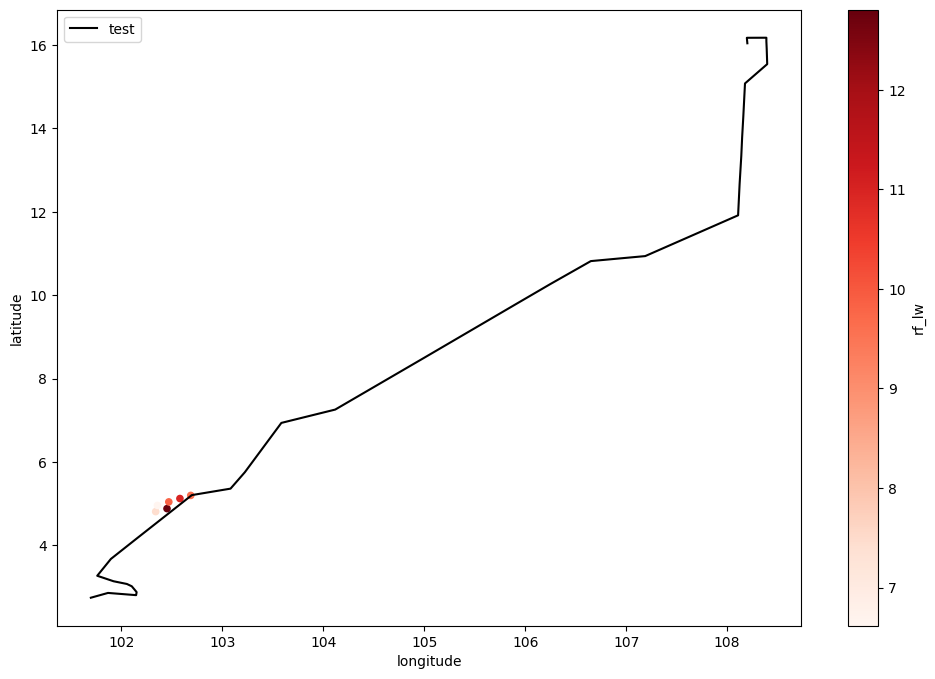

In [350]:
ax = cocip.source.dataframe.plot(
    "longitude", "latitude", color="k", label=fl_out.attrs["flight_id"], figsize=(12, 8)
)
cocip.contrail.plot.scatter("longitude", "latitude", c="rf_lw", cmap="Reds", ax=ax);

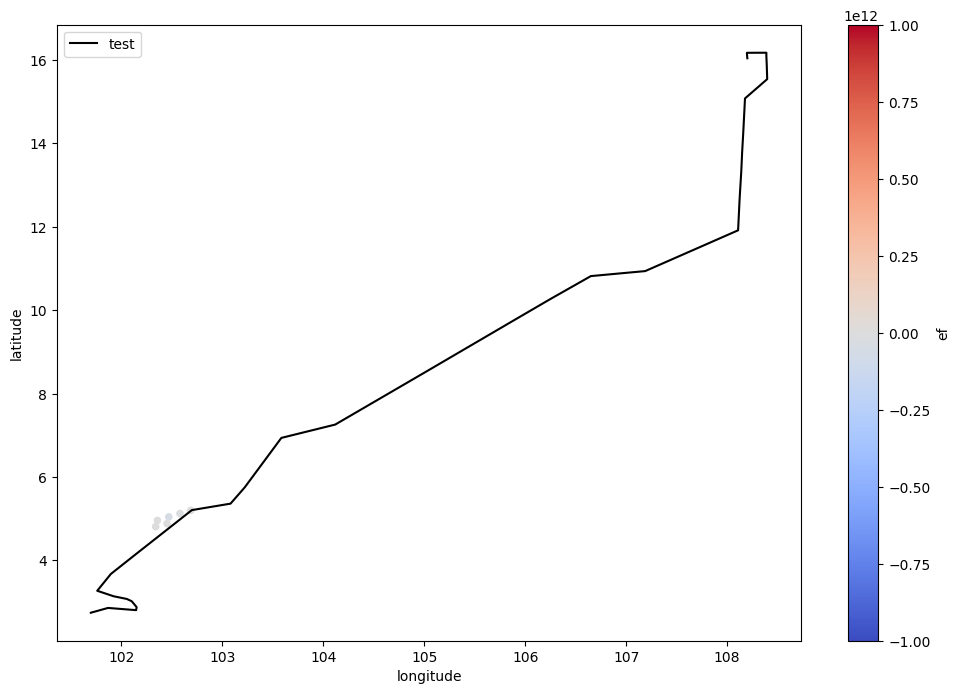

In [353]:
ax = cocip.source.dataframe.plot(
    "longitude", "latitude", color="k", label=fl_out.attrs["flight_id"], figsize=(12, 8)
)
cocip.contrail.plot.scatter(
    "longitude", "latitude", c="ef", cmap="coolwarm", vmin=-1e12, vmax=1e12, ax=ax
);